# Loading data from colorhunt

In [302]:
from urllib import request,parse
import json
import time
import random
from tqdm import trange

def load():
    data = []
    for i in trange(0,64,desc='Loading data'):
        body = parse.urlencode({'step':i,'sort':'new','tags':'','timeframe':30}).encode()
        Req = request.Request('https://colorhunt.co/php/feed.php',method='POST',headers={'content-type': 'application/x-www-form-urlencoded','User-Agent' :'Mozilla/4.0 (compatible; MSIE 5.5; Windows NT)'})
        readed = request.urlopen(Req,data=body).read()
        loads = json.loads(readed)
        data += loads
        time.sleep(random.randint(5,10)/100) # slow down to prevent http 429
    return data

with open('dataset/color.json','w') as f:
    f.write(json.dumps(load()))

Loading data: 100%|██████████| 64/64 [00:34<00:00,  1.88it/s]


# Process data


In [303]:
import json
import time
from tqdm import trange
import random

def color_code_split(code):
    return [f'#{code[i:i+6]}'.upper() for i in range(0,len(code),6)]

raw_data = []

with open('dataset/color.json','r') as f:
    raw_data = json.loads(f.read())

data = []
for i in trange(len(raw_data),desc="Transform color codes"):
    hex = color_code_split(raw_data[i]['code']) # transform color_code in data to hex
    for l in range(len(hex)):
        row = [str(i*4+l),hex[l],'|'.join(hex)] # create palette id
        row.append(raw_data[i]['likes'])
        data.append(row)
    # time.sleep(0.0001)

with open('dataset/color_processed.csv','w') as f:
    f.write("id,base,palette,likes\n" + '\n'.join([','.join(i) for i in data]))

Transform color codes: 100%|██████████| 2556/2556 [00:00<00:00, 98307.61it/s]


# Training

In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras.backend as K
from PIL import Image, ImageDraw
import os
from IPython import display
import time
import math

BUFFER_SIZE = 60000
BATCH_SIZE = 1
epoch = 100
def hex_2_rbg(hex):
    hex = hex.replace('##','#')
    r = (int('0x'+ hex[1:3],16))
    g = (int('0x'+ hex[3:5],16))
    b = (int('0x'+ hex[5:],16))
    return [r,g,b]


df = pd.read_csv('dataset/color_processed.csv')
df['base'] = df['base'].map(lambda hex: np.asarray([hex_2_rbg(hex)])/255)
df['palette'] = df['palette'].map(lambda hexs: np.asarray([[hex_2_rbg(i) for i in hexs.strip().split("|")]])/255)

x = []
y = []
for i in df['id']:
    x.append(df['base'][i])
    y.append(df['palette'][i])

train_x, test_x, train_y, test_y = train_test_split( np.array(x) , np.array(y) , test_size=0.1 )
set_per_epoch = int(math.ceil(len(train_y)/epoch))

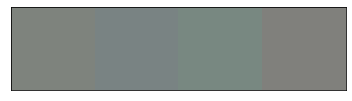

In [13]:
optimizer = Adam(0.0002,0.5)
def make_generator():
	model = keras.Sequential()
	model.add(layers.Input(3,))
	model.add(layers.Dense(1*4*128))
	model.add(layers.Reshape((1,4,128)))
	model.add(layers.Conv2DTranspose(64,(1,4),strides=1,padding="same"))
	model.add(layers.LeakyReLU(0.2))
	model.add(layers.Conv2DTranspose(128,(1,4),strides=1,padding="same"))
	model.add(layers.LeakyReLU(0.2))
	model.add(layers.Conv2D(3,(1,4),padding="same",activation="sigmoid"))
	model.compile(loss="binary_crossentropy",optimizer=optimizer)
	return model
generator = make_generator()
# generator.summary()
image = generator.predict([[1,1,1]])*255
plt.xticks([]);plt.yticks([])
plt.imshow(image.reshape((1,4,3)).astype('int'))
plt.show()


In [14]:
def make_discriminator():
    model = keras.Sequential()
    model.add(layers.Input(shape=(1,4,3)))
    model.add(layers.Conv2D(64,(1,4),strides=(1,1),padding="same"))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2D(128,(1,4),strides=(1,1),padding="same"))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1,activation="sigmoid"))
    model.compile(loss="binary_crossentropy",optimizer=optimizer)
    return model
discriminator = make_discriminator()
# discriminator.summary()


In [15]:
gan_input = layers.Input(3,)
fake_image = generator(gan_input)
gan_output = discriminator(fake_image)
gan = Model(gan_input,gan_output)
gan.compile(loss="binary_crossentropy",optimizer=optimizer)
# gan.summary()

In [16]:
history_d_loss = []
history_g_loss = []
history_train = []

100%|██████████| 93/93 [00:06<00:00, 13.50it/s]

epoch:$1 d_loss:$0.724404513835907 g_loss$0.4191811680793762
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [221, 23, 35]]]


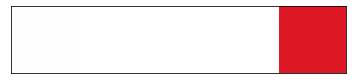

100%|██████████| 93/93 [00:06<00:00, 14.28it/s]

epoch:$2 d_loss:$0.7105998992919922 g_loss$0.43027329444885254
[[[255, 255, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [76, 195, 215]]]


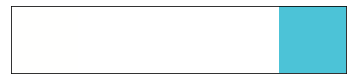

100%|██████████| 93/93 [00:06<00:00, 14.13it/s]

epoch:$3 d_loss:$0.6767637729644775 g_loss$0.37288621068000793
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [24, 69, 242]]]


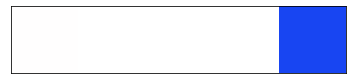

100%|██████████| 93/93 [00:06<00:00, 14.31it/s]

epoch:$4 d_loss:$0.7417261600494385 g_loss$0.4163550138473511
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [122, 234, 115]]]


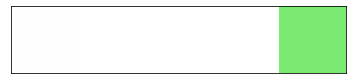

100%|██████████| 93/93 [00:06<00:00, 14.35it/s]

epoch:$5 d_loss:$0.7523488402366638 g_loss$0.3965161144733429
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [181, 46, 1]]]


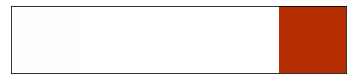

100%|██████████| 93/93 [00:06<00:00, 14.07it/s]

epoch:$6 d_loss:$0.7141187191009521 g_loss$0.3812703788280487
[[[255, 255, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [190, 239, 111]]]


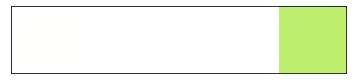

100%|██████████| 93/93 [00:07<00:00, 12.96it/s]

epoch:$7 d_loss:$0.7041366696357727 g_loss$0.4266779124736786
[[[255, 255, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [55, 215, 236]]]


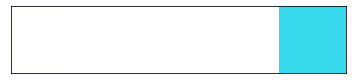

100%|██████████| 93/93 [00:06<00:00, 14.05it/s]

epoch:$8 d_loss:$0.6761980056762695 g_loss$0.445768803358078
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [124, 21, 247]]]


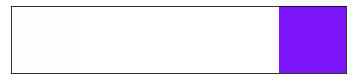

100%|██████████| 93/93 [00:06<00:00, 14.16it/s]


epoch:$9 d_loss:$0.7349907159805298 g_loss$0.43156158924102783
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [167, 41, 88]]]


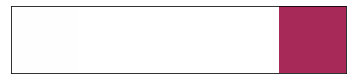

100%|██████████| 93/93 [00:06<00:00, 14.38it/s]

epoch:$10 d_loss:$0.7105879187583923 g_loss$0.3787607252597809
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [140, 30, 131]]]


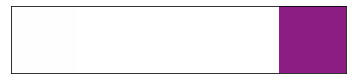

100%|██████████| 93/93 [00:06<00:00, 14.46it/s]

epoch:$11 d_loss:$0.7365591526031494 g_loss$0.39742907881736755
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [97, 93, 15]]]


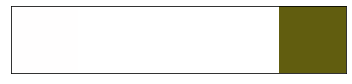

100%|██████████| 93/93 [00:06<00:00, 14.54it/s]

epoch:$12 d_loss:$0.7256028652191162 g_loss$0.41694822907447815
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [112, 193, 80]]]


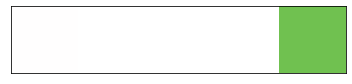

100%|██████████| 93/93 [00:06<00:00, 14.00it/s]

epoch:$13 d_loss:$0.7242313027381897 g_loss$0.3993116021156311
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [10, 131, 190]]]


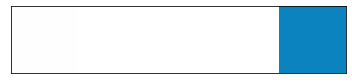

100%|██████████| 93/93 [00:06<00:00, 13.86it/s]


epoch:$14 d_loss:$0.7370104193687439 g_loss$0.4210564196109772
[[[255, 255, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [198, 82, 164]]]


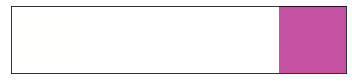

100%|██████████| 93/93 [00:07<00:00, 13.17it/s]

epoch:$15 d_loss:$0.7189804315567017 g_loss$0.38463637232780457
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [43, 117, 5]]]


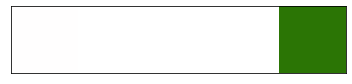

100%|██████████| 93/93 [00:06<00:00, 13.74it/s]

epoch:$16 d_loss:$0.7385386228561401 g_loss$0.4233638346195221
[[[255, 255, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [165, 226, 76]]]


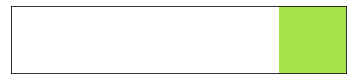

100%|██████████| 93/93 [00:06<00:00, 13.59it/s]

epoch:$17 d_loss:$0.7005839347839355 g_loss$0.3955983519554138
[[[255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [254, 178, 227]]]


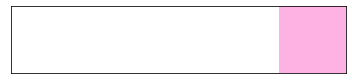

100%|██████████| 93/93 [00:07<00:00, 12.01it/s]


epoch:$18 d_loss:$0.7149494886398315 g_loss$0.3902941346168518
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [175, 196, 81]]]


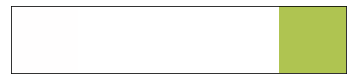

100%|██████████| 93/93 [00:07<00:00, 12.71it/s]

epoch:$19 d_loss:$0.7057746648788452 g_loss$0.385000079870224
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [79, 36, 86]]]


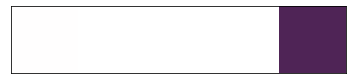

100%|██████████| 93/93 [00:07<00:00, 13.28it/s]


epoch:$20 d_loss:$0.7375317811965942 g_loss$0.41590064764022827
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [10, 72, 24]]]


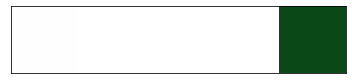

100%|██████████| 93/93 [00:06<00:00, 13.75it/s]

epoch:$21 d_loss:$0.7350335717201233 g_loss$0.3756619095802307
[[[255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [240, 218, 93]]]


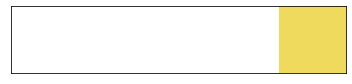

100%|██████████| 93/93 [00:06<00:00, 14.60it/s]

epoch:$22 d_loss:$0.7218351364135742 g_loss$0.4069916009902954
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [66, 61, 92]]]


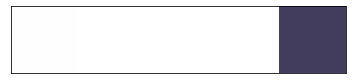

100%|██████████| 93/93 [00:06<00:00, 15.23it/s]

epoch:$23 d_loss:$0.7092509269714355 g_loss$0.3786832094192505
[[[255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [187, 176, 175]]]


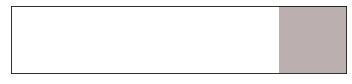

100%|██████████| 93/93 [00:06<00:00, 14.98it/s]

epoch:$24 d_loss:$0.7448111176490784 g_loss$0.43801629543304443
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [217, 230, 4]]]


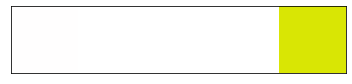

100%|██████████| 93/93 [00:06<00:00, 15.19it/s]

epoch:$25 d_loss:$0.7054960131645203 g_loss$0.39888280630111694
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [124, 135, 89]]]


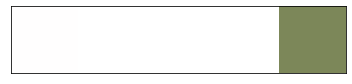

100%|██████████| 93/93 [00:06<00:00, 15.23it/s]

epoch:$26 d_loss:$0.7714825868606567 g_loss$0.4293939769268036
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [46, 81, 36]]]


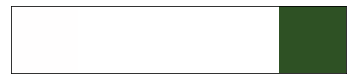

100%|██████████| 93/93 [00:06<00:00, 14.97it/s]


epoch:$27 d_loss:$0.7211724519729614 g_loss$0.40664568543434143
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [237, 118, 46]]]


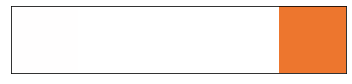

100%|██████████| 93/93 [00:06<00:00, 14.28it/s]

epoch:$28 d_loss:$0.7027467489242554 g_loss$0.3920755684375763
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [104, 134, 95]]]


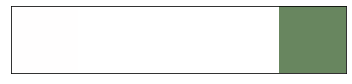

100%|██████████| 93/93 [00:06<00:00, 14.69it/s]

epoch:$29 d_loss:$0.702321469783783 g_loss$0.4167954623699188
[[[255, 255, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [169, 144, 207]]]


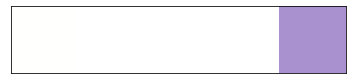

100%|██████████| 93/93 [00:06<00:00, 13.94it/s]

epoch:$30 d_loss:$0.7277777194976807 g_loss$0.4031118154525757
[[[255, 255, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [232, 102, 122]]]


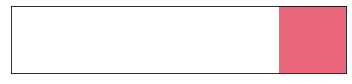

100%|██████████| 93/93 [00:06<00:00, 13.58it/s]


epoch:$31 d_loss:$0.7044965028762817 g_loss$0.41060149669647217
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [112, 126, 174]]]


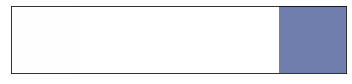

100%|██████████| 93/93 [00:07<00:00, 12.60it/s]

epoch:$32 d_loss:$0.7000824213027954 g_loss$0.38317298889160156
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [57, 116, 19]]]


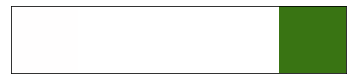

100%|██████████| 93/93 [00:06<00:00, 14.17it/s]

epoch:$33 d_loss:$0.6776383519172668 g_loss$0.4124599099159241
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [191, 1, 0]]]


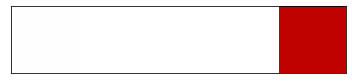

100%|██████████| 93/93 [00:06<00:00, 14.32it/s]

epoch:$34 d_loss:$0.6930221319198608 g_loss$0.42883142828941345
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [65, 116, 174]]]


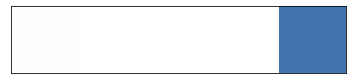

100%|██████████| 93/93 [00:06<00:00, 14.87it/s]

epoch:$35 d_loss:$0.6978012323379517 g_loss$0.38501572608947754
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [13, 161, 56]]]


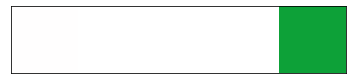

100%|██████████| 93/93 [00:06<00:00, 14.25it/s]

epoch:$36 d_loss:$0.6908634305000305 g_loss$0.40366876125335693
[[[255, 254, 254], [255, 255, 254], [255, 255, 255], [255, 254, 255], [29, 11, 6]]]


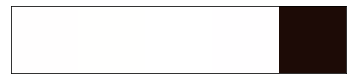

100%|██████████| 93/93 [00:06<00:00, 13.95it/s]

epoch:$37 d_loss:$0.7169238328933716 g_loss$0.41036558151245117
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [122, 110, 107]]]


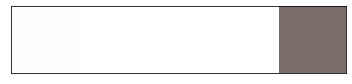

100%|██████████| 93/93 [00:06<00:00, 14.67it/s]

epoch:$38 d_loss:$0.6860756874084473 g_loss$0.40348243713378906
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [196, 131, 123]]]


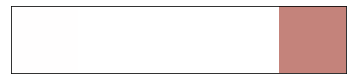

100%|██████████| 93/93 [00:06<00:00, 14.26it/s]

epoch:$39 d_loss:$0.7258395552635193 g_loss$0.4328577518463135
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [15, 21, 129]]]


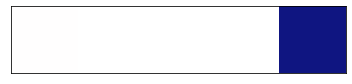

100%|██████████| 93/93 [00:06<00:00, 15.05it/s]

epoch:$40 d_loss:$0.6868586540222168 g_loss$0.4246215224266052
[[[255, 254, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [191, 49, 9]]]


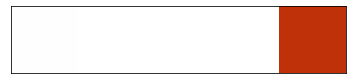

100%|██████████| 93/93 [00:06<00:00, 14.89it/s]

epoch:$41 d_loss:$0.8508344888687134 g_loss$0.35593345761299133
[[[255, 0, 0], [255, 0, 0], [255, 254, 254], [255, 255, 255], [223, 203, 191]]]


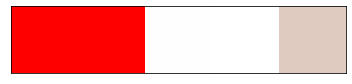

100%|██████████| 93/93 [00:06<00:00, 14.80it/s]

epoch:$42 d_loss:$0.7884907126426697 g_loss$0.32042160630226135
[[[255, 254, 254], [255, 255, 254], [254, 255, 243], [0, 0, 0], [226, 206, 225]]]


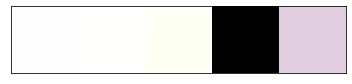

100%|██████████| 93/93 [00:06<00:00, 14.64it/s]

epoch:$43 d_loss:$0.7585594654083252 g_loss$0.40074095129966736
[[[255, 254, 254], [255, 255, 254], [254, 255, 152], [1, 0, 139], [110, 228, 167]]]


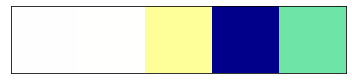

100%|██████████| 93/93 [00:06<00:00, 14.57it/s]

epoch:$44 d_loss:$0.8362016677856445 g_loss$0.34506353735923767
[[[255, 0, 254], [255, 255, 254], [255, 255, 254], [255, 254, 83], [121, 248, 108]]]


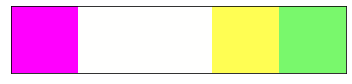

100%|██████████| 93/93 [00:06<00:00, 15.15it/s]

epoch:$45 d_loss:$0.7287945747375488 g_loss$0.3933985233306885
[[[255, 0, 254], [255, 254, 254], [255, 255, 254], [255, 254, 88], [221, 220, 62]]]


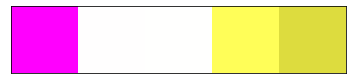

100%|██████████| 93/93 [00:06<00:00, 15.01it/s]

epoch:$46 d_loss:$0.7746259570121765 g_loss$0.4229664206504822
[[[255, 0, 254], [255, 255, 254], [255, 255, 253], [254, 254, 3], [212, 215, 49]]]


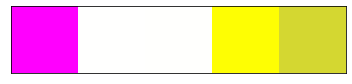

100%|██████████| 93/93 [00:06<00:00, 15.05it/s]

epoch:$47 d_loss:$0.7761890888214111 g_loss$0.396879106760025
[[[255, 0, 253], [255, 254, 3], [255, 255, 11], [254, 254, 252], [30, 216, 177]]]


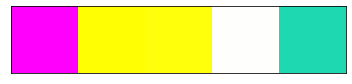

100%|██████████| 93/93 [00:06<00:00, 14.80it/s]

epoch:$48 d_loss:$0.913314938545227 g_loss$0.28425148129463196
[[[246, 251, 184], [247, 254, 161], [19, 0, 16], [1, 0, 70], [75, 181, 1]]]


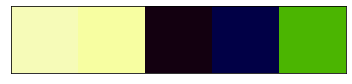

100%|██████████| 93/93 [00:07<00:00, 12.70it/s]

epoch:$49 d_loss:$0.9863864779472351 g_loss$0.2945166826248169
[[[0, 3, 7], [0, 0, 94], [7, 0, 146], [254, 248, 96], [146, 148, 29]]]


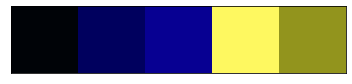

100%|██████████| 93/93 [00:06<00:00, 13.87it/s]

epoch:$50 d_loss:$0.8087001442909241 g_loss$0.40513649582862854
[[[1, 0, 1], [246, 0, 74], [61, 0, 124], [254, 254, 97], [205, 57, 168]]]


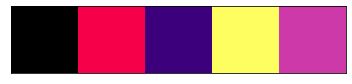

100%|██████████| 93/93 [00:06<00:00, 14.43it/s]


epoch:$51 d_loss:$0.7997922897338867 g_loss$0.38150933384895325
[[[2, 8, 4], [112, 0, 117], [157, 0, 83], [254, 254, 214], [74, 254, 119]]]


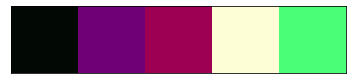

100%|██████████| 93/93 [00:06<00:00, 14.11it/s]

epoch:$52 d_loss:$0.8498236536979675 g_loss$0.2983202636241913
[[[254, 254, 151], [254, 254, 229], [235, 246, 160], [6, 132, 91], [67, 169, 120]]]


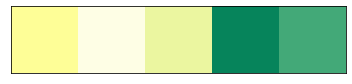

100%|██████████| 93/93 [00:06<00:00, 13.79it/s]

epoch:$53 d_loss:$0.8174470067024231 g_loss$0.3516627848148346
[[[254, 254, 237], [255, 255, 198], [254, 252, 190], [246, 29, 84], [236, 129, 208]]]


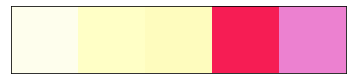

100%|██████████| 93/93 [00:06<00:00, 13.59it/s]

epoch:$54 d_loss:$0.8007403612136841 g_loss$0.3544418513774872
[[[254, 254, 236], [255, 254, 224], [254, 253, 125], [253, 146, 208], [42, 246, 45]]]


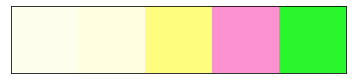

100%|██████████| 93/93 [00:06<00:00, 13.37it/s]

epoch:$55 d_loss:$0.7898642420768738 g_loss$0.3586287498474121
[[[254, 254, 224], [254, 254, 52], [254, 243, 188], [251, 112, 186], [33, 30, 160]]]


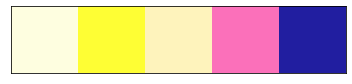

100%|██████████| 93/93 [00:07<00:00, 12.92it/s]


epoch:$56 d_loss:$0.9053816795349121 g_loss$0.28400173783302307
[[[17, 39, 86], [9, 2, 25], [7, 251, 139], [127, 254, 204], [19, 135, 167]]]


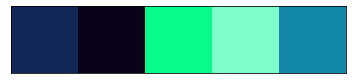

100%|██████████| 93/93 [00:07<00:00, 13.15it/s]

epoch:$57 d_loss:$0.8146137595176697 g_loss$0.3898831903934479
[[[13, 2, 38], [91, 1, 147], [250, 254, 144], [249, 254, 157], [200, 2, 4]]]


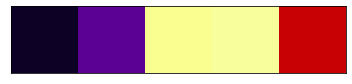

100%|██████████| 93/93 [00:07<00:00, 13.06it/s]

epoch:$58 d_loss:$0.7344233989715576 g_loss$0.3547859191894531
[[[192, 1, 23], [252, 8, 131], [254, 254, 146], [254, 254, 197], [190, 12, 79]]]


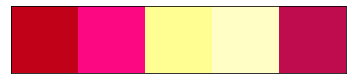

100%|██████████| 93/93 [00:08<00:00, 11.36it/s]

epoch:$59 d_loss:$0.7944604754447937 g_loss$0.40168583393096924
[[[93, 170, 220], [226, 253, 185], [168, 254, 251], [14, 254, 244], [103, 30, 119]]]


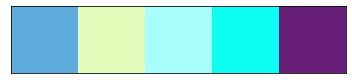

100%|██████████| 93/93 [00:07<00:00, 12.50it/s]


epoch:$60 d_loss:$0.8075127005577087 g_loss$0.4165053069591522
[[[147, 118, 217], [254, 254, 166], [237, 254, 254], [1, 254, 249], [163, 193, 232]]]


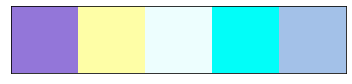

100%|██████████| 93/93 [00:07<00:00, 12.53it/s]

epoch:$61 d_loss:$0.8009625673294067 g_loss$0.3421878218650818
[[[254, 249, 209], [254, 254, 252], [254, 254, 254], [254, 254, 15], [48, 195, 190]]]


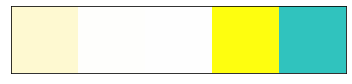

100%|██████████| 93/93 [00:06<00:00, 14.58it/s]

epoch:$62 d_loss:$0.7967751026153564 g_loss$0.3826068937778473
[[[252, 250, 227], [254, 254, 248], [254, 254, 253], [254, 246, 235], [24, 135, 15]]]


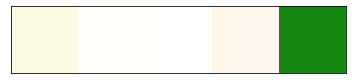

100%|██████████| 93/93 [00:06<00:00, 14.76it/s]

epoch:$63 d_loss:$0.7593463063240051 g_loss$0.37651151418685913
[[[254, 253, 238], [254, 254, 226], [254, 249, 252], [254, 1, 236], [145, 32, 72]]]


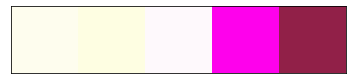

100%|██████████| 93/93 [00:07<00:00, 12.22it/s]


epoch:$64 d_loss:$0.7733936309814453 g_loss$0.4183277487754822
[[[254, 240, 107], [254, 4, 140], [254, 0, 3], [254, 0, 221], [214, 10, 6]]]


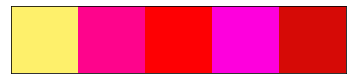

100%|██████████| 93/93 [00:06<00:00, 14.73it/s]

epoch:$65 d_loss:$0.7711280584335327 g_loss$0.3678298890590668
[[[254, 254, 91], [255, 0, 160], [254, 0, 0], [255, 0, 251], [238, 237, 218]]]


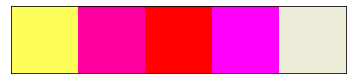

100%|██████████| 93/93 [00:06<00:00, 14.84it/s]

epoch:$66 d_loss:$0.8300487995147705 g_loss$0.2915057837963104
[[[216, 215, 155], [214, 103, 166], [185, 196, 60], [176, 195, 194], [16, 196, 114]]]


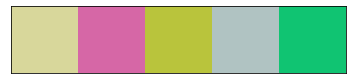

100%|██████████| 93/93 [00:06<00:00, 14.85it/s]

epoch:$67 d_loss:$0.8819239139556885 g_loss$0.29135769605636597
[[[41, 48, 97], [94, 109, 64], [129, 88, 66], [97, 67, 89], [155, 191, 199]]]


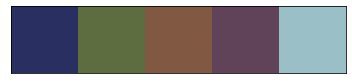

100%|██████████| 93/93 [00:06<00:00, 14.13it/s]

epoch:$68 d_loss:$0.9431023001670837 g_loss$0.28733325004577637
[[[51, 27, 48], [93, 128, 111], [175, 160, 136], [236, 193, 160], [91, 246, 111]]]


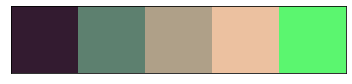

100%|██████████| 93/93 [00:06<00:00, 14.44it/s]

epoch:$69 d_loss:$0.860582709312439 g_loss$0.34097644686698914
[[[73, 45, 106], [173, 166, 130], [190, 146, 161], [254, 241, 184], [154, 111, 236]]]


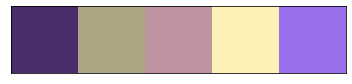

100%|██████████| 93/93 [00:06<00:00, 14.11it/s]

epoch:$70 d_loss:$0.8198108673095703 g_loss$0.33944079279899597
[[[247, 241, 205], [138, 190, 237], [132, 181, 221], [254, 177, 215], [136, 153, 73]]]


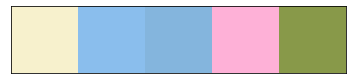

100%|██████████| 93/93 [00:06<00:00, 13.58it/s]

epoch:$71 d_loss:$0.8372085690498352 g_loss$0.36232122778892517
[[[235, 236, 159], [207, 230, 132], [135, 106, 142], [246, 129, 90], [19, 159, 54]]]


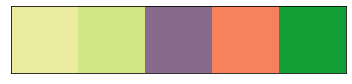

100%|██████████| 93/93 [00:06<00:00, 14.07it/s]

epoch:$72 d_loss:$0.9239217638969421 g_loss$0.2928362786769867
[[[198, 69, 59], [226, 22, 68], [206, 108, 75], [13, 51, 56], [210, 196, 167]]]


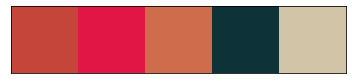

100%|██████████| 93/93 [00:06<00:00, 13.55it/s]

epoch:$73 d_loss:$0.868150532245636 g_loss$0.3502008318901062
[[[16, 56, 126], [169, 202, 178], [254, 235, 229], [252, 229, 234], [163, 65, 94]]]


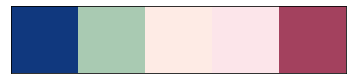

100%|██████████| 93/93 [00:06<00:00, 14.22it/s]

epoch:$74 d_loss:$0.8096379637718201 g_loss$0.3188899755477905
[[[26, 188, 200], [97, 154, 153], [253, 160, 97], [251, 218, 162], [86, 88, 101]]]


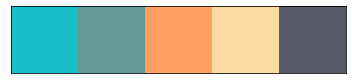

100%|██████████| 93/93 [00:06<00:00, 14.17it/s]

epoch:$75 d_loss:$0.8756344318389893 g_loss$0.34260937571525574
[[[254, 246, 100], [253, 210, 214], [246, 91, 166], [18, 47, 100], [230, 53, 126]]]


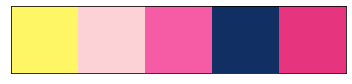

100%|██████████| 93/93 [00:06<00:00, 14.39it/s]

epoch:$76 d_loss:$0.875618577003479 g_loss$0.2848658263683319
[[[250, 55, 232], [4, 62, 80], [9, 180, 106], [235, 201, 77], [250, 193, 28]]]


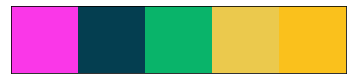

100%|██████████| 93/93 [00:06<00:00, 14.84it/s]

epoch:$77 d_loss:$0.8664958477020264 g_loss$0.33349141478538513
[[[222, 40, 61], [218, 188, 177], [249, 233, 199], [242, 208, 180], [9, 128, 44]]]


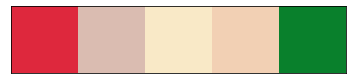

100%|██████████| 93/93 [00:06<00:00, 14.83it/s]

epoch:$78 d_loss:$0.8556625843048096 g_loss$0.3613754212856293
[[[80, 152, 101], [252, 235, 161], [244, 131, 76], [89, 60, 87], [4, 208, 102]]]


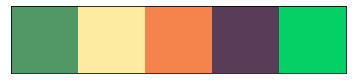

100%|██████████| 93/93 [00:06<00:00, 15.00it/s]

epoch:$79 d_loss:$0.8934317827224731 g_loss$0.3550529181957245
[[[222, 190, 185], [105, 72, 98], [91, 84, 94], [94, 115, 116], [8, 12, 181]]]


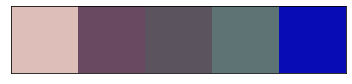

100%|██████████| 93/93 [00:06<00:00, 14.78it/s]

epoch:$80 d_loss:$0.8396540880203247 g_loss$0.28384310007095337
[[[8, 118, 213], [43, 122, 162], [252, 218, 114], [251, 221, 128], [181, 240, 129]]]


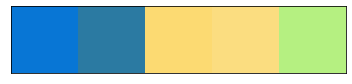

100%|██████████| 93/93 [00:06<00:00, 14.30it/s]

epoch:$81 d_loss:$0.8330226540565491 g_loss$0.3159503936767578
[[[154, 186, 74], [254, 116, 201], [254, 242, 250], [254, 253, 246], [123, 83, 181]]]


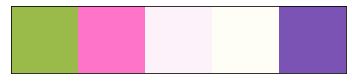

100%|██████████| 93/93 [00:06<00:00, 14.54it/s]

epoch:$82 d_loss:$0.819717288017273 g_loss$0.40096405148506165
[[[111, 245, 232], [254, 253, 252], [254, 246, 254], [254, 254, 250], [46, 245, 134]]]


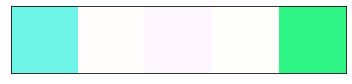

100%|██████████| 93/93 [00:06<00:00, 14.33it/s]

epoch:$83 d_loss:$0.8043565154075623 g_loss$0.3888006806373596
[[[247, 252, 244], [254, 253, 152], [254, 98, 240], [254, 240, 19], [140, 65, 149]]]


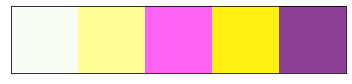

100%|██████████| 93/93 [00:06<00:00, 13.76it/s]

epoch:$84 d_loss:$0.7635555863380432 g_loss$0.3666880130767822
[[[254, 254, 1], [255, 254, 0], [255, 254, 0], [254, 0, 0], [158, 251, 246]]]


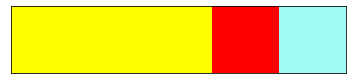

100%|██████████| 93/93 [00:06<00:00, 15.18it/s]

epoch:$85 d_loss:$0.8147050142288208 g_loss$0.3539305329322815
[[[254, 254, 248], [254, 254, 254], [0, 200, 245], [0, 1, 51], [108, 154, 199]]]


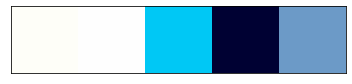

100%|██████████| 93/93 [00:06<00:00, 15.03it/s]

epoch:$86 d_loss:$0.852450430393219 g_loss$0.3270736038684845
[[[140, 2, 13], [204, 1, 9], [253, 140, 70], [254, 235, 169], [219, 35, 73]]]


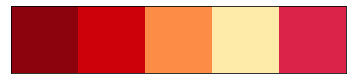

100%|██████████| 93/93 [00:06<00:00, 13.85it/s]

epoch:$87 d_loss:$0.8672987818717957 g_loss$0.3562932312488556
[[[152, 167, 171], [252, 242, 217], [228, 107, 163], [119, 67, 132], [179, 135, 148]]]


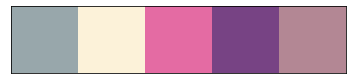

100%|██████████| 93/93 [00:06<00:00, 14.57it/s]

epoch:$88 d_loss:$0.8525186777114868 g_loss$0.33564484119415283
[[[206, 160, 187], [60, 145, 146], [92, 118, 142], [109, 97, 126], [10, 20, 118]]]


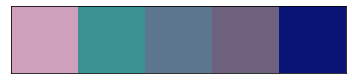

100%|██████████| 93/93 [00:07<00:00, 13.15it/s]

epoch:$89 d_loss:$0.9442804455757141 g_loss$0.3094845116138458
[[[98, 38, 79], [119, 86, 115], [123, 187, 149], [200, 200, 155], [169, 226, 9]]]


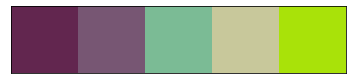

100%|██████████| 93/93 [00:06<00:00, 14.91it/s]

epoch:$90 d_loss:$0.8459104299545288 g_loss$0.3725752532482147
[[[153, 55, 70], [246, 172, 91], [238, 146, 68], [153, 228, 165], [234, 205, 35]]]


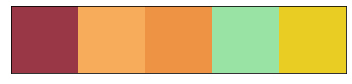

100%|██████████| 93/93 [00:06<00:00, 14.08it/s]

epoch:$91 d_loss:$0.8820878267288208 g_loss$0.33263349533081055
[[[254, 250, 248], [254, 244, 231], [179, 82, 94], [163, 25, 22], [45, 164, 134]]]


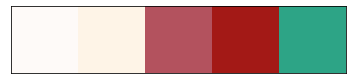

100%|██████████| 93/93 [00:06<00:00, 13.35it/s]

epoch:$92 d_loss:$0.9383812546730042 g_loss$0.2725661098957062
[[[164, 71, 80], [17, 37, 58], [134, 172, 186], [186, 181, 178], [66, 145, 72]]]


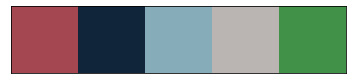

100%|██████████| 93/93 [00:06<00:00, 14.39it/s]

epoch:$93 d_loss:$0.8814342617988586 g_loss$0.3127892017364502
[[[21, 226, 241], [242, 252, 241], [253, 230, 83], [252, 88, 60], [141, 143, 40]]]


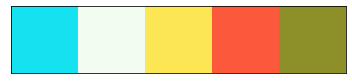

100%|██████████| 93/93 [00:06<00:00, 14.87it/s]

epoch:$94 d_loss:$0.8769986629486084 g_loss$0.3529190421104431
[[[10, 102, 45], [128, 62, 60], [249, 104, 99], [253, 243, 163], [8, 247, 194]]]


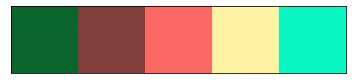

100%|██████████| 93/93 [00:06<00:00, 14.90it/s]

epoch:$95 d_loss:$0.8386943340301514 g_loss$0.36013537645339966
[[[254, 253, 248], [254, 254, 252], [0, 240, 244], [5, 179, 234], [175, 148, 178]]]


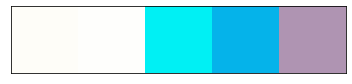

100%|██████████| 93/93 [00:06<00:00, 15.15it/s]

epoch:$96 d_loss:$0.7861537933349609 g_loss$0.337137907743454
[[[252, 206, 228], [71, 56, 30], [1, 79, 40], [61, 38, 15], [23, 46, 170]]]


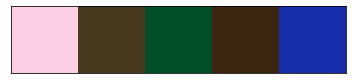

100%|██████████| 93/93 [00:06<00:00, 14.80it/s]

epoch:$97 d_loss:$0.945493221282959 g_loss$0.3431834280490875
[[[132, 105, 91], [244, 15, 103], [254, 91, 24], [251, 164, 208], [77, 241, 204]]]


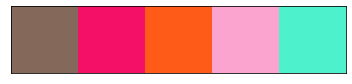

100%|██████████| 93/93 [00:06<00:00, 14.64it/s]

epoch:$98 d_loss:$0.8411696553230286 g_loss$0.36369210481643677
[[[251, 94, 66], [244, 183, 108], [254, 62, 106], [10, 76, 59], [244, 238, 144]]]


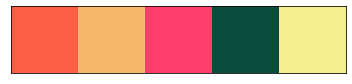

100%|██████████| 93/93 [00:06<00:00, 14.68it/s]

epoch:$99 d_loss:$0.8963432312011719 g_loss$0.31820017099380493
[[[21, 45, 81], [37, 92, 168], [132, 221, 193], [239, 241, 211], [171, 85, 97]]]


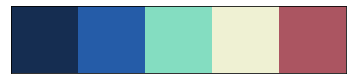

100%|██████████| 93/93 [00:06<00:00, 14.88it/s]

epoch:$100 d_loss:$0.8841512203216553 g_loss$0.3121577799320221
[[[136, 237, 223], [249, 234, 117], [205, 108, 144], [249, 248, 132], [49, 134, 252]]]


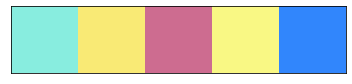

INFO:tensorflow:Assets written to: ./_generator\assets
INFO:tensorflow:Assets written to: ./_discriminator\assets
INFO:tensorflow:Assets written to: ./_gan\assets
done!


In [18]:
from tqdm import tqdm

for e in range(1,epoch+1):
    for n in tqdm(range(set_per_epoch)):
        fake_x = generator.predict(train_x[e*n])
        real_x = train_y[[e*n]]
        x = np.concatenate((real_x, fake_x))
        disc_y = np.zeros(2)
        disc_y[:1] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(1)
        g_loss = gan.train_on_batch(train_x[e*n], y_gen)
        history_d_loss.append(d_loss)
        history_g_loss.append(g_loss)
        history_train.append(len(history_d_loss))
    print(f'epoch:${e} d_loss:${d_loss} g_loss${g_loss}')
    rand = np.asarray([np.random.uniform(0,1,3)])
    image = generator.predict(rand)*255
    image = image.reshape((1,4,3)).astype('int')
    image = image.tolist()
    image[0]+=(rand*255).astype('int').tolist()
    print(image)
    plt.xticks([]);plt.yticks([])
    plt.imshow(image)
    plt.show()
generator.save('./_generator')
discriminator.save('./_discriminator')
gan.save('./_gan')
generator.save_weights('./_generator')
discriminator.save_weights('./_discriminator')
gan.save_weights('./_gan')
print("done!")
